In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt


## Creation of artificial data

Data are created artificially with a mixed Gaussian distribution of two clusters, with specific means and standard deviations

In [2]:

def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)
    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.show()
    #Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = -1 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    return samples

## Train model
Train the model using the least squares approach

In [4]:
  
  def estimateOptimumW(TargetsAll, SamplesAll, P = 20, coefAprendizaje = 1):
    """ 
    Train model
    Estimate the optimum W with NO FORS, only for epochs
    param TargetsAll, NumSamples x 1 matrix with target values (1 or -1)
    param SamplesAll, NumSamples x NumDimensions 
    return wOpt, array with optimum weights
    """
    #implementar el criterio del perceptron, hacer aleatorio    
    wOpt = torch.ones(3, 1) 
    #lista de errores 
    
    errorPerEpoch = []    
    for epoch in range(0, P):
        #no reescribir la matriz de observaciones
        SamplesAllIter = SamplesAll.clone()
        #Calcular el vector gradiente
        #crear un ciclo que se va a repetir por P veces, cantidad de epochs
        perceptronCriterion = SamplesAllIter.mm(wOpt) * TargetsAll 
        #seleccionar las observaciones incorrectamente clasificadas por el modelo con pesos wOpt, 
        #usando el crit. del perceptron
        perceptronCriterion_mat = perceptronCriterion.mm(torch.ones(1, 3))             
        SamplesAllIter[perceptronCriterion_mat >= 0] = 0        
        #calculate error gradient       
        error_grad_all_observations = SamplesAllIter * TargetsAll              
        error_grad_sum = torch.sum(error_grad_all_observations, 0)       
        #make it a column matrix 
        error_grad_sum = error_grad_sum.unsqueeze(0).transpose(0, 1)              
        #Actualizar el vector de pesos        
        wOpt = wOpt + coefAprendizaje * error_grad_sum           
        #Imprimir el error total
        EstimatedTargets = forward(SamplesAll, wOpt)        
        error = evaluateError(TargetsAll, EstimatedTargets)
        #print("Epoch: ", epoch, " error: ", error)
        errorPerEpoch += [error]
    return wOpt, errorPerEpoch
  
  def forward(SamplesAll, wOpt):
    """
    Get model output, with NO FORS
    param TargetsAll
    return EstimatedTargets, with 1 or -1
    """
    EstimatedTargetsAll = SamplesAll.mm(wOpt)
    EstimatedTargetsAll[EstimatedTargetsAll >= 0] = 1
    EstimatedTargetsAll[EstimatedTargetsAll < 0] = -1
    return EstimatedTargetsAll   
    
   
  
  def evaluateError(TargetsAll, EstimatedTargetsAll):
    """
    Evaluate model error using the euclidian distance
    param TargetsAll, real targets
    param EstimatedTargets
    """
    error = torch.norm(TargetsAll - EstimatedTargetsAll, 2)
    return error

## Main function and error graphing by epoch

The main function creates the dataset and trains the perceptron, to finally plot the error by epoch.

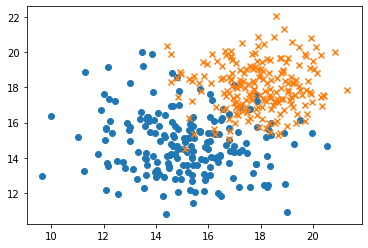

Final error with training data
tensor(12.1655)


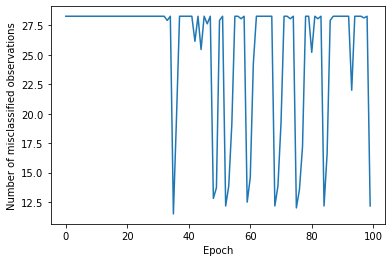

In [17]:
"""
Main function
"""
def main():
    (TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 200, mean1 = [15, 15], mean2 = [18, 18], stds1 = [3, 3], stds2 = [2, 2])    
    wOpt = torch.ones(3, 1)
    #Evaluar el forward
    #EstimatedTargets = forward(SamplesAll, wOpt)    
    wOpt, errorPerEpoch = estimateOptimumW(TargetsAll, SamplesAll, P = 100, coefAprendizaje = 0.00001)    
    EstimatedTargetsAll = forward(SamplesAll, wOpt)
    print("Final error with training data")
    error = evaluateError(TargetsAll, EstimatedTargetsAll)        
    print(error)
    plt.plot(errorPerEpoch)
    plt.ylabel("Number of misclassified observations")
    plt.xlabel("Epoch")
    plt.show()
    
    
    
        
main()

In [11]:
a = torch.tensor([5, 6, 7, 8, 9])
b = a > 6
a[a > 6] = -20
print(b)
print(a)

tensor([False, False,  True,  True,  True])
tensor([  5,   6, -20, -20, -20])


In [12]:
#multiplicacion element wise
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([2.0, 5.0, 3.0])
c = a * b
print(c)

tensor([ 2., 10.,  9.])
